In [76]:
cd C:\Users\venka\OneDrive\Desktop\BTP\Data\source_doublet_vortex\train_data\val

C:\Users\venka\OneDrive\Desktop\BTP\Data\source_doublet_vortex\train_data\val


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from  scipy import ndimage
from cv2 import cv2
from matplotlib.image import imread,imsave
import plotly.figure_factory as ff
import plotly.graph_objects as go
import math

Define the required parameters

In [3]:
h = 224
w = 224
nmax=10
l=4
types=['source_sink','doublet','vortex']
dictype={type:i for i,type in enumerate(types)}

Create a meshgrid

In [4]:
x = np.linspace(-5, 5, h)
y = np.linspace(-5, 5, w)
X, Y = np.meshgrid(x, y)

In [5]:
X

array([[-5.        , -4.95515695, -4.9103139 , ...,  4.9103139 ,
         4.95515695,  5.        ],
       [-5.        , -4.95515695, -4.9103139 , ...,  4.9103139 ,
         4.95515695,  5.        ],
       [-5.        , -4.95515695, -4.9103139 , ...,  4.9103139 ,
         4.95515695,  5.        ],
       ...,
       [-5.        , -4.95515695, -4.9103139 , ...,  4.9103139 ,
         4.95515695,  5.        ],
       [-5.        , -4.95515695, -4.9103139 , ...,  4.9103139 ,
         4.95515695,  5.        ],
       [-5.        , -4.95515695, -4.9103139 , ...,  4.9103139 ,
         4.95515695,  5.        ]])

In [6]:
Y

array([[-5.        , -5.        , -5.        , ..., -5.        ,
        -5.        , -5.        ],
       [-4.95515695, -4.95515695, -4.95515695, ..., -4.95515695,
        -4.95515695, -4.95515695],
       [-4.9103139 , -4.9103139 , -4.9103139 , ..., -4.9103139 ,
        -4.9103139 , -4.9103139 ],
       ...,
       [ 4.9103139 ,  4.9103139 ,  4.9103139 , ...,  4.9103139 ,
         4.9103139 ,  4.9103139 ],
       [ 4.95515695,  4.95515695,  4.95515695, ...,  4.95515695,
         4.95515695,  4.95515695],
       [ 5.        ,  5.        ,  5.        , ...,  5.        ,
         5.        ,  5.        ]])

Functions for elementary flows

In [7]:
def source_sink(x0,y0,X,Y):
    import math
    #Set strength limit
    pi=math.pi
    smax=100
    choose=random.randint(0,1)
    if choose==0:
        strength=random.randint(-1*smax,-1*smax//2)
    else:
        strength=random.randint(smax//2,smax)
    U=(strength/(2*pi))*(X-x0)/((X-x0)**2+(Y-y0)**2)
    V=(strength/(2*pi))*(Y-y0)/((X-x0)**2+(Y-y0)**2)    
    return [U,V,strength]

def doublet(x0,y0,X,Y):
    import math
    #Set strength limit
    pi=math.pi
    smax=75
    strength=random.randint(smax//2,smax)
    U=(strength/(2*pi))*((X-x0)**2-(Y-y0)**2)/((X-x0)**2+(Y-y0)**2)**2
    V=(strength/(2*pi))*(2*(X-x0)*(Y-y0))/((X-x0)**2+(Y-y0)**2)**2 
    return [U,V,strength]

def vortex(x0,y0,X,Y):
    import math
    #Set strength limit
    pi=math.pi
    smax=75
    strength=random.randint(smax//2,smax)
    U=(strength/(2*pi))*((Y-y0))/((X-x0)**2+(Y-y0)**2)
    V=(strength/(2*pi))*(-1*(X-x0))/((X-x0)**2+(Y-y0)**2)
    return [U,V,strength]

In [8]:
strength_val=[]
bbox = []
imgname=[]
raw_vel=[]

In [9]:
for i in range(200):
    if (i+1)%100==0:
        print(i+1)
    #choose number of flows
    number_of_flows=random.randint(0,nmax)
    points=[]
    while(len(points)<number_of_flows):
        x0=np.random.choice(np.linspace(-1*l, l, h))
        y0=np.random.choice(np.linspace(-1*l, l, h))
        flag=1
        for point in points:
            x=point[0]
            y=point[1]
            if ((x0-x)**2+(y0-y)**2)**0.5<1.5:
                flag=0
        if flag==1:
            points.append([x0,y0])
    vel1x=np.zeros_like(X)
    vel2x=np.zeros_like(X)
    text=[]
    strength_text=[]
    for point in points:
        type=np.random.choice(types)
        x0=point[0]
        y0=point[1]
        text.append(str(dictype[type])+' '+str((x0+l+1)/(2*l+2))+' '+str((y0+l+1)/(2*l+2))+' 0.12'+' 0.12'+' \n')
        if type=='source_sink':
            vel=source_sink(x0,y0,X,Y)
            vel1x+=vel[0]
            vel2x+=vel[1]
        if type=='doublet':
            vel=doublet(x0,y0,X,Y)
            vel1x+=vel[0]
            vel2x+=vel[1]
        if type=='vortex':
            vel=vortex(x0,y0,X,Y)
            vel1x+=vel[0]
            vel2x+=vel[1]
        strength_text.append(vel[2])
    vel1x[np.isnan(vel1x)]=0
    vel2x[np.isnan(vel2x)]=0

    U=ndimage.median_filter(vel1x,size=(5,5))
    V=ndimage.median_filter(vel2x,size=(5,5))
    T=(U**2+V**2)**0.5

    ru=U
    rv=V
    rt=T
    
    U=(U-U.min())/(U.max()-U.min())
    V=(V-V.min())/(V.max()-V.min())
    T=(T-T.min())/(T.max()-T.min())

    rgb=np.dstack((U,V,T))
    raw_rbg=np.dstack((ru,rv,rt))
    raw_vel.append(raw_rbg)
    imsave('images/'+'image'+str(i)+'.png', rgb)
    imgname.append('image'+str(i)+'.png')
    file1 = open('labels/image'+str(i)+".txt","w")
    bbox.append(''.join(text))
    L = text
    file1.writelines(L)
    file1.close()
    strength_val.append(strength_text)

<ipython-input-9-459d1892fa91>:51: RuntimeWarning: invalid value encountered in true_divide
  U=(U-U.min())/(U.max()-U.min())
<ipython-input-9-459d1892fa91>:52: RuntimeWarning: invalid value encountered in true_divide
  V=(V-V.min())/(V.max()-V.min())
<ipython-input-9-459d1892fa91>:53: RuntimeWarning: invalid value encountered in true_divide
  T=(T-T.min())/(T.max()-T.min())


100
200


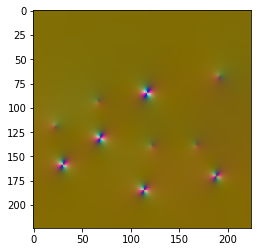

In [10]:
plt.imshow(rgb)

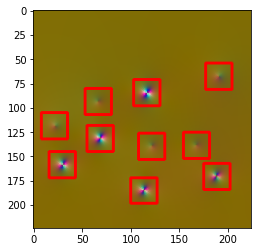

In [11]:
image = rgb.copy()
for t in text:
    t=t.split()
    xmid=float(t[1])
    ymid=float(t[2])
    rgb2=cv2.rectangle(image,(int((xmid-0.06)*224),int((ymid-0.06)*224)),(int((xmid+0.06)*224),int((ymid+0.06)*224)),(1,0,0),2)
plt.imshow(rgb2)

In [12]:
df = pd.DataFrame()

In [13]:
strength_series=[]
for s in strength_val:
    s=list(map(str,s))
    strength_series.append(' '.join(s))

In [14]:
df['imagename']=imgname
df['bbox']=bbox
df['strength_val']=strength_series

In [15]:
df

,imagename,bbox,strength_val
0,image0.png,0 0.3654708520179372 0.3834080717488789 0.12 0...,54 62 69 51 69 61 58
1,image1.png,2 0.16457399103139014 0.1681614349775785 0.12 ...,70 53
2,image2.png,0 0.8174887892376681 0.5556053811659193 0.12 0...,67
3,image3.png,2 0.2434977578475336 0.14304932735426007 0.12 ...,61 65
4,image4.png,1 0.6130044843049327 0.26502242152466365 0.12 ...,51
...,...,...,...
195,image195.png,1 0.7887892376681614 0.7098654708520179 0.12 0...,56 55 69 51 55 71 68 61 60
196,image196.png,1 0.6381165919282511 0.46591928251121073 0.12 ...,45 -59 55 54 -87 48 69 38
197,image197.png,0 0.7780269058295964 0.48744394618834086 0.12 ...,77 72 -61 98 70 46 53 41 -89 66
198,image198.png,1 0.13228699551569506 0.27578475336322866 0.12...,53 54 61


In [16]:
df.to_csv('strength_details.csv',index=False)

In [17]:
np.save('raw_vel_files',raw_vel)

# Preparing the Data for finding the strength

In [77]:
df = pd.read_csv('strength_details.csv')

In [78]:
df

,imagename,bbox,strength_val
0,image0.png,0 0.3654708520179372 0.3834080717488789 0.12 0...,54 62 69 51 69 61 58
1,image1.png,2 0.16457399103139014 0.1681614349775785 0.12 ...,70 53
2,image2.png,0 0.8174887892376681 0.5556053811659193 0.12 0...,67
3,image3.png,2 0.2434977578475336 0.14304932735426007 0.12 ...,61 65
4,image4.png,1 0.6130044843049327 0.26502242152466365 0.12 ...,51
...,...,...,...
195,image195.png,1 0.7887892376681614 0.7098654708520179 0.12 0...,56 55 69 51 55 71 68 61 60
196,image196.png,1 0.6381165919282511 0.46591928251121073 0.12 ...,45 -59 55 54 -87 48 69 38
197,image197.png,0 0.7780269058295964 0.48744394618834086 0.12 ...,77 72 -61 98 70 46 53 41 -89 66
198,image198.png,1 0.13228699551569506 0.27578475336322866 0.12...,53 54 61


In [79]:
bbox = df['bbox'].tolist()
strength_val = df['strength_val'].tolist()

In [80]:
raw_vel = np.load('raw_vel_files.npy')

In [81]:
raw_vel.shape

(200, 224, 224, 3)

In [82]:
raw_vel[0].shape

(224, 224, 3)

In [83]:
source_sink = []
source_sink_sth = []
doublet = []
doublet_sth = []
vortex = []
vortex_sth = []

In [84]:
bbox[0].split('\n')

['0 0.3654708520179372 0.3834080717488789 0.12 0.12 ',
 '1 0.1179372197309417 0.4228699551569507 0.12 0.12 ',
 '0 0.7026905829596413 0.6130044843049327 0.12 0.12 ',
 '2 0.34394618834080715 0.867713004484305 0.12 0.12 ',
 '1 0.48026905829596417 0.6130044843049327 0.12 0.12 ',
 '1 0.27578475336322866 0.7242152466367713 0.12 0.12 ',
 '1 0.8426008968609866 0.4443946188340807 0.12 0.12 ',
 '']

In [85]:
for i,record in enumerate(bbox):
    try:
        record = record.split('\n')
        strength = strength_val[i].split()
        for j,box in enumerate(record):
            if box!= '':
                box = box.split()
                typ = box[0]
                startx = int((float(box[1]) - float(box[3])/2)*h)
                starty = int((float(box[2]) - float(box[4])/2)*w)
                sx = int(float(box[3])*w)
                sy = int(float(box[4])*h)
                if typ == '0':
                    source_sink.append(raw_vel[i][starty:starty+sy,startx:startx+sx,:])
                    source_sink_sth.append(float(strength[j]))
                if typ == '1':
                    doublet.append(raw_vel[i][starty:starty+sy,startx:startx+sx,:])
                    doublet_sth.append(float(strength[j]))
                if typ == '2':
                    vortex.append(raw_vel[i][starty:starty+sy,startx:startx+sx,:])
                    vortex_sth.append(float(strength[j]))
    except:
        pass

In [86]:
len(source_sink),len(doublet),len(vortex)

(334, 317, 322)

In [87]:
len(source_sink_sth),len(doublet_sth),len(vortex_sth)

(334, 317, 322)

In [88]:
np.save('source_sink_val',source_sink)

In [89]:
np.save('source_sink_sth_val',source_sink_sth)

In [90]:
np.save('doublet_val',doublet)

In [91]:
np.save('doublet_sth_val',doublet_sth)

In [92]:
np.save('vortex_val',vortex)

In [93]:
np.save('vortex_sth_val',vortex_sth)